# New Quantum Processing Unit

We have developed a new form of quantum processing unit. This quantum processing unit is based on encoding features into a superposition of single photon states, and evaluating their similarity measure as a form of kernel based machine learning. 

# KME and MMD with Fock states and HOM

In this notebook we will start with some data that has been highly separted into categories as if by using some Resnet, or other machine learning method.

We will then describe a method to encode this data into quantum states using MMD.

We will will run through the notebook chronologically. For the purpose of this notebook we will only work with 2D data, but it can be easily generalised

### 1. Load data

We will start by a train and test data-set using sklearns blob data, for the sake of narative, we will call blob 1 'ants' and blob 2 'bees'.

In [4]:
import math
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm

#Create data 
Nsamples = 1000
centers = 2
random_state = 0
cluster_std = 1
X, Y = make_blobs(n_samples=Nsamples,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)

# Make some test data from same specifications 
Ntest = 1000
Xtest, Ytest = make_blobs(n_samples=Ntest,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)

#Normalise the Data 
M = np.absolute(np.concatenate((X, Xtest)))

# Normalise data using pi (this will become important)
X_mod = ((math.pi)/(M.max()))*X
Xtest_mod=((math.pi)/(M.max()))*Xtest

We will now break the data into classifications and then plot it on the Cartesian plane

In [5]:
#define category groups 
y0 = np.where(Y == 0)
y1 = np.where(Y == 1)

# Classify data points
X_mod_0 = X_mod[y0]
X_mod_1 = X_mod[y1]

#Get Averages 
Xavg0 = np.mean(X_mod_0, axis=0)
Xavg1 = np.mean(X_mod_1, axis=0)  

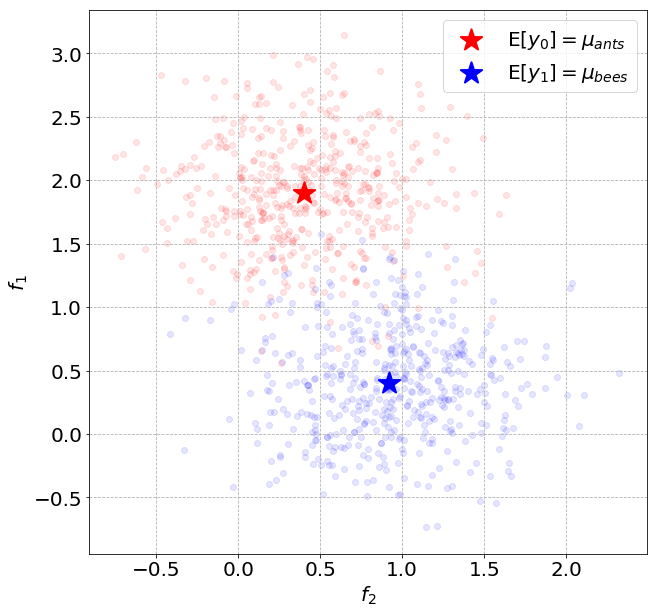

In [6]:
# Plot Cost function
ap = 0.1
sz = 500
fs = 20

# Plot data 
fig = plt.figure(figsize=(10,10))

plt.scatter(X_mod_0[:,0], X_mod_0[:,1], color='r', alpha=ap)
plt.scatter(X_mod_1[:,0], X_mod_1[:,1], color='b', alpha=ap)

plt.scatter(Xavg0[0], Xavg0[1], color='r', marker='*', s=sz, linewidth=2, label=r'$\mathrm{E}[y_{0}] = \mu_{ants}$')
plt.scatter(Xavg1[0], Xavg1[1], color='b', marker='*', s=sz, linewidth=2, label=r'$\mathrm{E}[y_{1}] = \mu_{bees}$')

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$f_{1}$', fontsize=fs)
plt.xlabel(r'$f_{2}$', fontsize=fs)


plt.legend(fontsize=fs)

plt.show()

Let's first apply a linear support Vector machine to this 

In [4]:
clf = svm.SVC(kernel='linear', gamma=2, C=1)

clf.fit(X_mod, Y)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 0.1, x.max() + 0.1
    y_min, y_max = y.min() - 0.1, y.max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

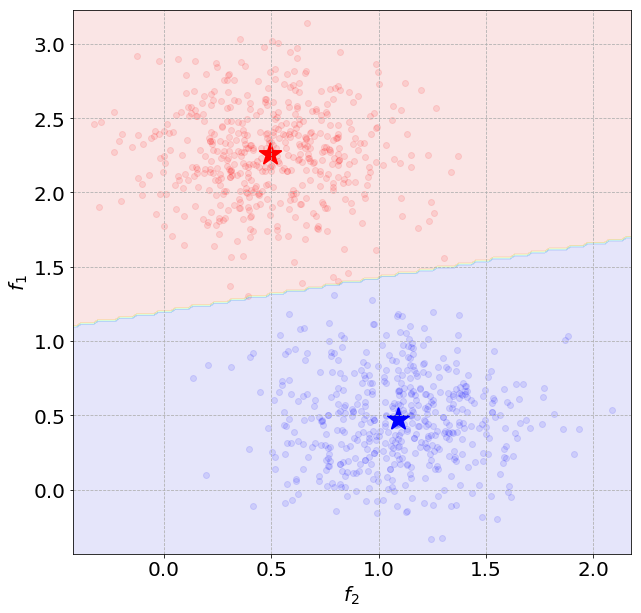

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot Cost function
ap = 0.1
sz = 500
fs = 20

plt.scatter(X_mod_0[:,0], X_mod_0[:,1], color='r', alpha=ap)
plt.scatter(X_mod_1[:,0], X_mod_1[:,1], color='b', alpha=ap)

# Now plot our boundary as a contour (use training data to create boundary)
xx, yy = make_meshgrid(X_mod[:, 0], X_mod[:,1])
plot_contours(ax, clf, xx, yy, cmap='jet_r', alpha=ap)

plt.scatter(Xavg0[0], Xavg0[1], color='r', marker='*', s=sz, linewidth=2, label=r'$\mathrm{E}[y_{0}] = \mu_{ants}$')
plt.scatter(Xavg1[0], Xavg1[1], color='b', marker='*', s=sz, linewidth=2, label=r'$\mathrm{E}[y_{1}] = \mu_{bees}$')

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$f_{1}$', fontsize=fs)
plt.xlabel(r'$f_{2}$', fontsize=fs)

plt.show()

We will now define our first part of the algorithm. 

To make the most of quantum mechanical feature space, we need an encoding that can be mapped to all parts of the Hilbert space. For 2D data, this can be encoded into the Bloch sphere (3 spherical coordinates), which correspond to the amplitude and phase of the quantum state. 

For 2D data it is very straight forward to map to spherical coordinates however, for nD data this is more tricky.

For 2D data, each data point $y_{i} = (f_{1}, f_{2})$ is defined by two features. 

What is important here is the following: If we naievly map our features above onto a sphere, this data might not be maximally separated on the sphere. Thus we give each feature a corresponding weight in the nsphere encoding. This weight allows us to change the mapping to the nsphere to maximise the separation on the sphere.

We can show this below by setting the weights to 1 and then mapping the data onto a sphere.

In [6]:
# Map to the Nsphere 

def nsphere(mean, w):
    
    N = len(mean)
    
    # Create empty vectors
    T_vector = np.zeros(N+1)
    
    # Define first parameter
    T_vector[0] = np.cos(w[0]*mean[0])
    
    # update n-1 parameters
    for n in range (1, N):
        T_vector[n] = T_vector[n-1]*((np.cos(w[n-1]*mean[n-1]))**-1)*(np.sin(w[n-1]*mean[n-1]))*(np.cos(w[n]*mean[n]))
    
    # Update last parameter
    T_vector[N] = T_vector[N-1]*((np.cos(w[N-1]*mean[N-1]))**-1)*(np.sin(w[N-1]*mean[N-1]))
    
    # Retur T_vector
    return T_vector

In [7]:
#plot blank data to see whole Nsphere 
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

# Unit weights
weights = [1, 1]

#Create nsphere data of initial data
X0Nsphere = np.array([nsphere(X0, weights) for X0 in X_mod_0])
X1Nsphere = np.array([nsphere(X1, weights) for X1 in X_mod_1])

#Determine Averages 
Xavg0S = nsphere(Xavg0, weights)
Xavg1S = nsphere(Xavg1, weights) 

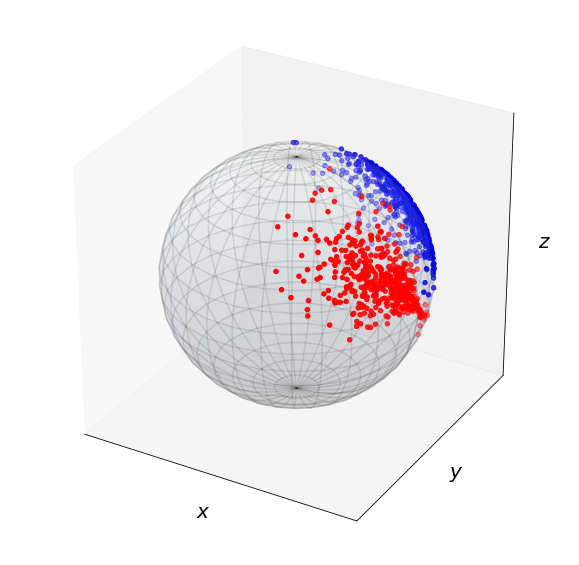

In [8]:
# Map data to sphere
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.bone, alpha = ap)
ax.plot_wireframe(x, y, z, color="k", alpha=0.1)
#ax.scatter(Xavg0S[0], Xavg0S[1], Xavg0S[2], color='r', marker='*', s=sz, linewidth=2)
#ax.scatter(Xavg1S[0], Xavg1S[1], Xavg1S[2], color='b', marker='*', s=sz, linewidth=2)
ax.scatter(X0Nsphere[:,0], X0Nsphere[:,1], X0Nsphere[:,2],  color='r')#, alpha=ap)
ax.scatter(X1Nsphere[:,0], X1Nsphere[:,1], X1Nsphere[:,2], color='b')#, alpha=ap)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel(r'$x$', fontsize=fs)
ax.set_ylabel(r'$y$', fontsize=fs)
ax.set_zlabel(r'$z$', fontsize=fs)

plt.show()

Clearly in the above plot, the two distributions are not maximally separated in the Bloch sphere, and the means do not correspond to orthogonal states. We want to change the weights in our encoding to maximise these separation of these distributions on the Bloch sphere. To do this we will need MMD.

# MMD

We now define the maximum mean discrepancy which is defined as 
\begin{equation}
MMD^{2} = \vert \vert \mu _{ants} - \mu_{bees} \vert \vert^{2}
\end{equation}

In [9]:
#Define Maximum Mean discrepancy calculation
def MMD(mean_1, mean_2):
    
    MMD = np.linalg.norm(mean_1 - mean_2)**2
    return MMD

# Gradient

In this algorithm we only need to know whether the cost function is increasing or decreasing. 

Therefore we need to check whether or not the cost function has increased or decreased. If it is decreasing, keep stepping in the right direction. If it increases, take a step in a random direction. 

\begin{equation}
G_{n} = MMD(X_0, X_1,w_{n}) - MMD(X_0, X_1, w_{n-1})
\end{equation}

In [10]:
# Calculating the gradient in the cost function (MMD)
def Grad(XM0, XM1, wN, wM):
    
    #XM0 is the mean of class0 
    #XM1 is the mean of class 1
    # wN is current weight
    # wM is previous weight
    
    # Grad = val1 - val2
    val1 = np.array(MMD(nsphere(XM0, wN), nsphere(XM1, wN)))
    val2 = np.array(MMD(nsphere(XM0, wM), nsphere(XM1, wM)))
    
    return val1 - val2

# Putting it all together

We can now put this all together into a single algorithm where we use the idea of gradient descent to maximise the MMD. 

The algorithm runs as follows:

1. Define number of iterations and epochs
2. Calculate the means of the two distributions
3. 

In [11]:
#Define a function to update weight values based on a stochastic gradient decent with momentum

def train(XM0, XM1, epoch, L):
    
    # L is step size
    
    # Initialise random weights and arrays
    w = np.zeros((epoch, 2))
    w_direc = np.zeros((epoch, 2))
    Cost = np.zeros(epoch)
    w[0] = np.array([1,1])
    w_direc[1] = np.random.randint(-1,2, size=2)
    
    
    w[1] = w[0] + w_direc[1]*L
    for i in range(2, epoch):
        
        # Compute cost function
        Cost[i-1] = MMD(nsphere(XM0, w[i-1]), nsphere(XM1, w[i-1]))
        gradC = -Grad(XM0, XM1, w[i-1], w[i-2])
        
        # Update gradient based off rule
        if gradC < 0:
            w_direc[i] =  w_direc[i-1]
        else:
            w_direc[i] = np.random.randint(-1,2, size=2)
        
        # Schedule learning rate
        if Cost[i-1] > 0.2: 
            w[i] = w[i-1] + (w_direc[i]*L)
        else: 
            w[i] = w[i-1] + (w_direc[i]*L*0.1)
            
    return w, Cost, w_direc



We now run this algorithm with some chosen learning rate and a number of epochs. If we then plot the results we see that we maximise the discrepancy. The maximum discrepancy corresponds to $MMD = 4$ since the distance between two sides of the unit sphere is 2, which we then square.

In [12]:
# Set Learning rate and epochs
L = 0.03
epoch=500

# Train algorithm
[w, Cost, w_direc] = train(Xavg0, Xavg1, epoch, L)

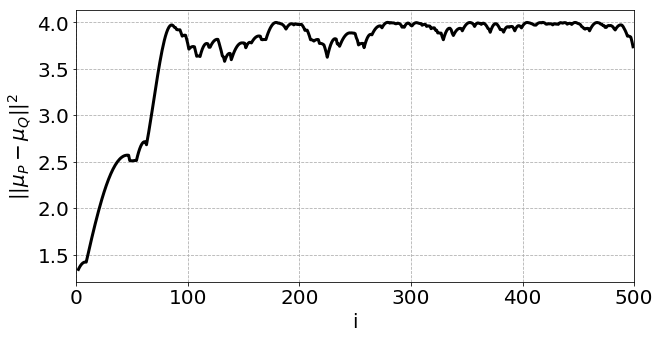

In [13]:
# Plot Cost function
ap = 0.1
sz = 500
fs = 20

epoch_graph = range(2, epoch)

plt.figure(figsize=(10,5))
plt.plot(epoch_graph, Cost[1:-1], color='k', linewidth=3)


plt.xlim([0, epoch])

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$|| \mu_{P} - \mu_{Q}||^{2}$', fontsize=fs)
plt.xlabel(r'$\mathrm{i}$', fontsize=fs)

plt.show()

We can further check the avereage convergance of this algorithm by running it many time and averaging over the results. 

In [14]:
# Set Learning rate and epochs
L = 0.03
epoch=500

# Get average cost function plot
iters = 100
Cost_list = np.zeros((iters, epoch))

# Train algorithm
for i in range(iters):
    [w, Cost, w_direc] = train(Xavg0, Xavg1, epoch, L)
    Cost_list[i] = Cost

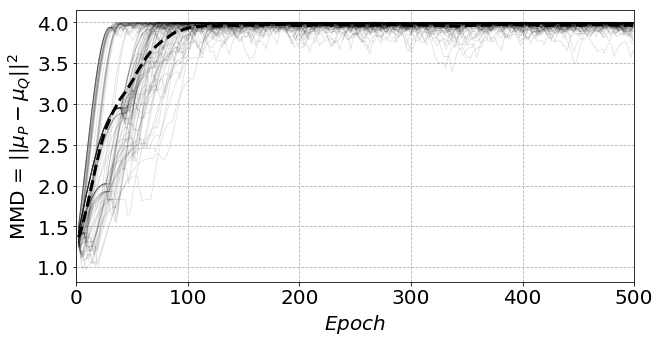

In [15]:
Cost_average = np.mean(Cost_list, axis=0)

# Plot Cost function
ap = 0.1
sz = 500
fs = 20

epoch_graph = range(2, epoch)

plt.figure(figsize=(10,5))
plt.plot(epoch_graph, Cost_average[1:-1], color='k', linewidth=3, linestyle='--')
plt.plot(epoch_graph, Cost_list.T[1:-1], color='k', linewidth=1, alpha=ap)

plt.xlim([0, epoch])

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'MMD = $|| \mu_{P} - \mu_{Q}||^{2}$', fontsize=fs)
plt.xlabel(r'$Epoch$', fontsize=fs)

plt.show()

Thus, we have optimised the weights to ensure that the means of distributions will be mapped to opposite sides of the spheres. All the other points will obey the same mapping so the distributions still contain the same information, they are just maximally separated according to their means.

This means that ants and bees are now maximally separated in our Hilbert space.

In [17]:
#plot blank data to see whole Nsphere 
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

#Create nsphere data of initial data
X0NsphereA = np.array([nsphere(X0, w[-1]) for X0 in X_mod_0])
X1NsphereA = np.array([nsphere(X1, w[-1]) for X1 in X_mod_1])

#Determine Averages 
Xavg0SA = nsphere(Xavg0, w[-1])
Xavg1SA = nsphere(Xavg1, w[-1]) 

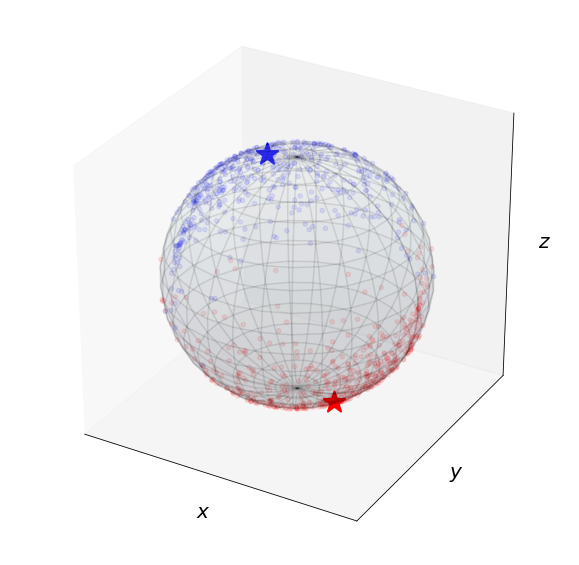

In [18]:
# plot the nsphere after training 
fig = plt.figure(figsize=(10,10))

ap = 0.1
sz = 500
fs = 20

ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.bone, alpha = ap)
ax.plot_wireframe(x, y, z, color="k", alpha=0.1)
ax.scatter(Xavg0SA[0], Xavg0SA[1], Xavg0SA[2], color='r', marker='*', s=sz, linewidth=2)
ax.scatter(Xavg1SA[0], Xavg1SA[1], Xavg1SA[2], color='b', marker='*', s=sz, linewidth=2)

ax.scatter(X0NsphereA[:,0], X0NsphereA[:,1], X0NsphereA[:,2],  color='r', alpha=ap)
ax.scatter(X1NsphereA[:,0], X1NsphereA[:,1], X1NsphereA[:,2], color='b', alpha=ap)
# ax.view_init(30, 30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel(r'$x$', fontsize=fs)
ax.set_ylabel(r'$y$', fontsize=fs)
ax.set_zlabel(r'$z$', fontsize=fs)


plt.show()



This becomes transformation becomes much clearer when the two spheres are plotted side-by-side, that is before and after. 

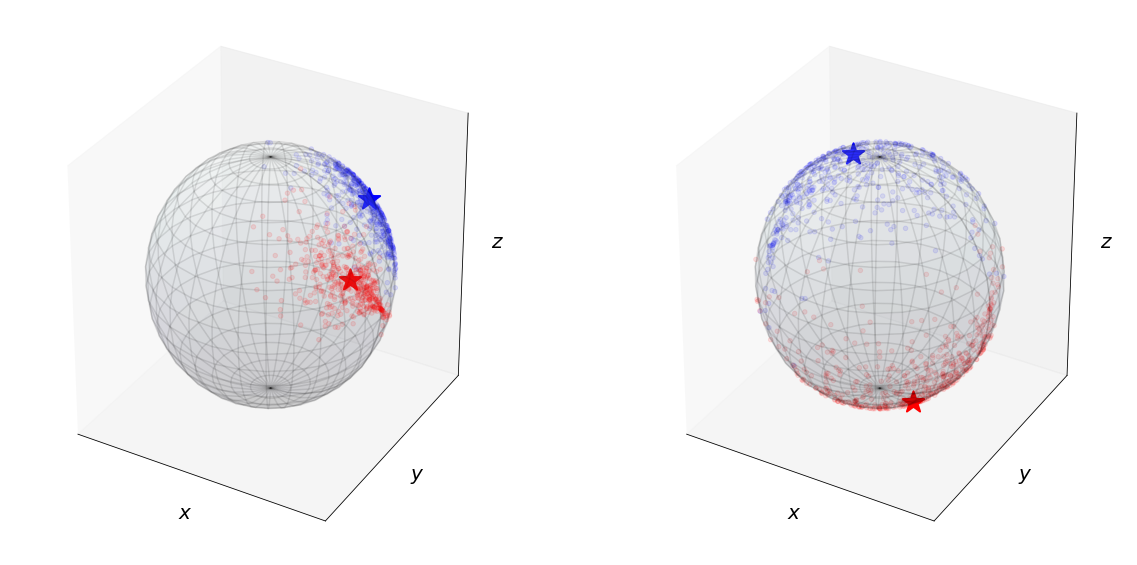

In [19]:
# plot the nsphere before and after training 
fig = plt.figure(figsize=(20,10))

ap = 0.1
sz = 500
fs = 20

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.bone, alpha = ap)
ax.plot_wireframe(x, y, z, color="k", alpha=0.1)
ax.scatter(Xavg0S[0], Xavg0S[1], Xavg0S[2], color='r', marker='*', s=sz, linewidth=2)
ax.scatter(Xavg1S[0], Xavg1S[1], Xavg1S[2], color='b', marker='*', s=sz, linewidth=2)
ax.scatter(X0Nsphere[:,0], X0Nsphere[:,1], X0Nsphere[:,2],  color='r', alpha=ap)
ax.scatter(X1Nsphere[:,0], X1Nsphere[:,1], X1Nsphere[:,2], color='b', alpha=ap)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel(r'$x$', fontsize=fs)
ax.set_ylabel(r'$y$', fontsize=fs)
ax.set_zlabel(r'$z$', fontsize=fs)

# ax.set_xlabel

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.bone, alpha = ap)
ax.plot_wireframe(x, y, z, color="k", alpha=0.1)
ax.scatter(Xavg0SA[0], Xavg0SA[1], Xavg0SA[2], color='r', marker='*', s=sz, linewidth=2)
ax.scatter(Xavg1SA[0], Xavg1SA[1], Xavg1SA[2], color='b', marker='*', s=sz, linewidth=2)

ax.scatter(X0NsphereA[:,0], X0NsphereA[:,1], X0NsphereA[:,2],  color='r', alpha=ap)
ax.scatter(X1NsphereA[:,0], X1NsphereA[:,1], X1NsphereA[:,2], color='b', alpha=ap)
# ax.view_init(30, 30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel(r'$x$', fontsize=fs)
ax.set_ylabel(r'$y$', fontsize=fs)
ax.set_zlabel(r'$z$', fontsize=fs)

plt.show()

# Encoding into Fock states

We now want to encode our data into Fock states.

Here we will use our x,y, and z coordinates to correspond to the weights. We transform from Cartesian to spherical coordinates according too 

$$
\theta = \arctan\left(\frac{\sqrt{x^{2} + y^{2}}}{z}\right)\,, \quad \phi = \arctan\left(\frac{y}{x}\right)
$$

where the quantum states coefficients then correspond to 

\begin{equation}
| \psi \rangle = \cos(\theta/2)|0\rangle + \sin(\theta/2) e^{i \phi}|1\rangle\,.
\end{equation}

This is a direct coneection between the Bloch sphere and the encoded states

In [20]:
# Using the average state we compute 
def cart2angles(cart):
    # Convert cartesian to angles
    theta = np.arccos(cart[2])
    phi = np.arctan2(cart[1], cart[0])
    
    return np.array([theta, phi])

def cart2coefs(cart):
    
    A = cart2angles(cart)
    
    return np.array([np.cos(A[0]/2), np.sin(A[0]/2)*np.exp(1j*A[1])])

If we compute the encoding using the inital weights and the trained weights, we can clearly see that the training makes the two classes encoded into orthogonal states.

In [21]:
# Compute coefficients for our states 
X0before = cart2coefs(Xavg0S)
X1before = cart2coefs(Xavg1S)

X0after = cart2coefs(Xavg0SA)
X1after = cart2coefs(Xavg1SA)

In [22]:
print('Overlap of means before training =', np.round(np.abs(np.dot(X0before, np.conj(X1before)))**2,3))
print('Overlap of means after training =', np.round(np.abs(np.dot(X0after, np.conj(X1after)))**2,3))

Overlap of means before training = 0.659
Overlap of means after training = 0.004


We can now visualise what these modes look like using our frequency encoded modes and the Hermite polynomials.

In [24]:
# Demonstration of Fock modes Before and After 
pi = np.pi
exp = np.exp
factorial = np.math.factorial

# start by definining frequency space
omegaf = 10
domega = 0.01
omega = np.arange(-omegaf, omegaf, domega)
d=len(nsphere(Xavg0, weights))

#define Hermite Polynomials 
from scipy import special

def Psin(omega, n):
    
    # Get hermite polynomial
    Hn = special.hermite(n)
    
    return np.exp(-omega**2 / 2)/(pi**(1/4) * (2**n * factorial(n))**(1/2)) * Hn(omega)

In [25]:
#Define Fock modes before training 
P0b = np.sum(np.array([coef*Psin(omega, n) for n, coef in enumerate(X0before)], dtype=complex), axis=0)
P1b = np.sum(np.array([coef*Psin(omega, n) for n, coef in enumerate(X1before)], dtype=complex), axis=0)

# Define Fock modes after training
P0A = np.sum(np.array([coef*Psin(omega, n) for n, coef in enumerate(X0after)], dtype=complex), axis=0)
P1A = np.sum(np.array([coef*Psin(omega, n) for n, coef in enumerate(X1after)], dtype=complex), axis=0)

# Compute Overlap 
OB = np.abs(np.sum(P0b*np.conj(P1b))*domega)**2
OA = np.abs(np.sum(P0A*np.conj(P1A))*domega)**2

We can now plot what our averages look like when they are encoded into Fock Modes before and after encoding

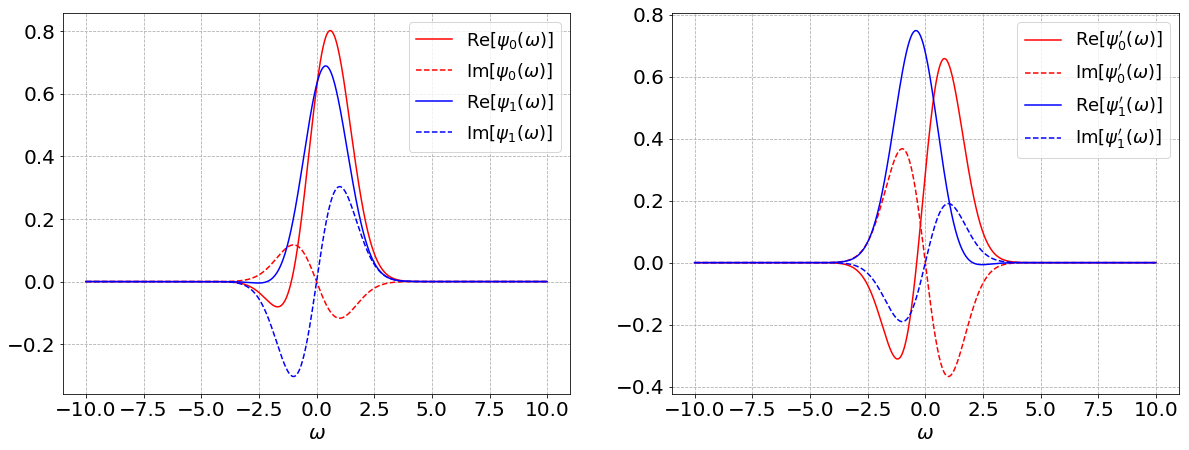

In [26]:
fs = 20

plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(omega, np.real(P0b) ,'r', label=r'$\mathrm{Re}[\psi_{0}(\omega)]$')
plt.plot(omega, np.imag(P0b), 'r--',  label=r'$\mathrm{Im}[\psi_{0}(\omega)]$')

plt.plot(omega, np.real(P1b) ,'b',  label=r'$\mathrm{Re}[\psi_{1}(\omega)]$')
plt.plot(omega, np.imag(P1b), 'b--',  label=r'$\mathrm{Im}[\psi_{1}(\omega)]$')

plt.xlabel(r'$\omega$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(omega, np.real(P0A) ,'r', label=r"$\mathrm{Re}[\psi_{0}'(\omega)]$")
plt.plot(omega, np.imag(P0A), 'r--', label=r"$\mathrm{Im}[\psi_{0}'(\omega)]$")

plt.plot(omega, np.real(P1A) ,'b', label=r"$\mathrm{Re}[\psi_{1}'(\omega)]$")
plt.plot(omega, np.imag(P1A), 'b--', label=r"$\mathrm{Im}[\psi_{1}'(\omega)]$")

plt.xlabel(r'$\omega$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--')

plt.show()

# Classifying data

Now that we have our weights trained, we want to classify unseen data. The above training will not improve the accuracy of our classification since we have not acquired any new information about the distributions, it will however make it much easier to classify using HOM interference.

Given that our means are maximally separated, then if they interact there will be no HOM dip, but if they are similar there will be a large dip. 

For example, if we our data was not maximally separated on the Bloch sphere, then our HOM dip would be large, which would make it near impossible to accurately classify data. Let's look at this. The distance between the bottom of the dip and our noise floor (which is zero), is the region in which we can classify data. 

In [27]:
def HOM(t, dt, Dt, psi0, psi1, d):
    
    '''
    t: time array 
    dt: timestep
    Dt: relative time difference between modes
    psi0: coefficients of the first state of dimension d
    psi1: coefficients of the second state of dimension d
    d: dimesnion of subspaces
    '''
    
    Psi1 = np.array([psi0[n]*Psin(t, n) for n in range(d)], dtype=complex)
    Psi2 = np.array([psi1[n]*Psin(t+Dt, n) for n in range(d)], dtype=complex)
    
    prod = np.abs(np.sum(np.conjugate(Psi1)*Psi2)*dt)**2
    
    return 1-prod

In [28]:
t = np.linspace(-10, 10, 1000)
dt = t[1]-t[0]
Dtvals = np.linspace(-5,5, 500)

d = len(X0before)

## Let's now compute the HOM dip before and after the data for the two means

Now the general idea is simple. We chose either mean to be a reference (say 'ants'). If we see a large HOM dip, then we know that the data point that we are measuring is an ant. If we see a much smaller dip then we know the data is not an 'ant' i.e it is a 'bee'.

Let's look at the dips before and after training the weights

In [29]:
# CC before
CCb = np.array([HOM(t, dt, Dt, X0before, X1before, d) for Dt in Dtvals])

# CC after
CCa = np.array([HOM(t, dt, Dt, X0after, X1after, d) for Dt in Dtvals])

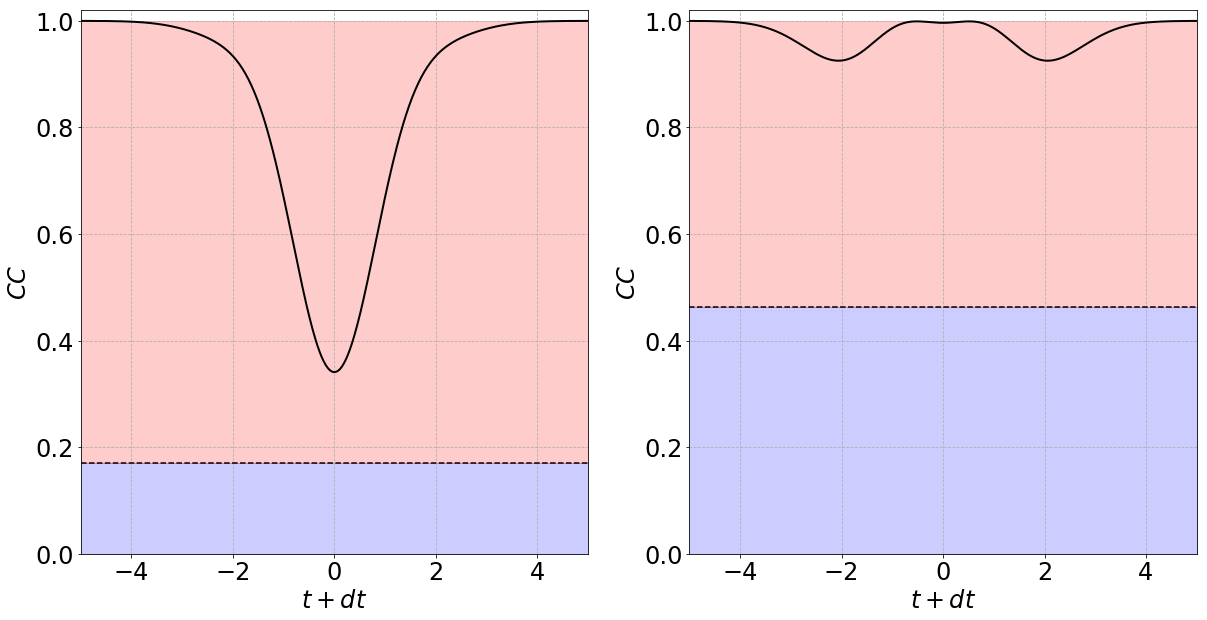

In [32]:
ap = 0.2
sz = 500
fs = 20

# Let's plot the data
plt.figure(figsize=(20,10))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.hlines(np.min(CCb)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCb)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCb)/2, 1, color='r', alpha=ap)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)

plt.plot(Dtvals, CCa, color='k', linewidth=2)
plt.hlines(np.min(CCa)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCa)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCa)/2, 1, color='r', alpha=ap)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')


plt.show()

Here the black line is the HOM dip corresponding to the average 'bee' interferred with the average 'ant'. You can see, that because the states are not perfectly orthognoal, then a dip is always present. This means the margin for us to distinguish ants from bees is much smaller (blue/red) area. If we now compare it to a random data point, and we observe a dip that is above the black dashed line, then we would say it's an ant. If the dip is below the dashed line, we would say the data is a bee. 

If we now compare this to after training, we can clearly see that the orthogonality much better. This dramatically increases our distinguisability area and pushes the middway point almost perfectly to 0.5. Let's now go and check where our data falls in this plot. 

In [33]:
# We now go and compute the HOM dip value for each of our ants and bees data point

X0coeffsb = np.array([cart2coefs(x0) for x0 in X0Nsphere])
X1coeffsb = np.array([cart2coefs(x1) for x1 in X1Nsphere])

X0dipb = 1-np.array([np.abs(np.dot(X1before, np.conj(x0)))**2 for x0 in X0coeffsb])
X1dipb = 1-np.array([np.abs(np.dot(X1before, np.conj(x1)))**2 for x1 in X1coeffsb])

X0coeffsa = np.array([cart2coefs(x0) for x0 in X0NsphereA])
X1coeffsa = np.array([cart2coefs(x1) for x1 in X1NsphereA])

X0dipa = 1-np.array([np.abs(np.dot(X1after, np.conj(x0)))**2 for x0 in X0coeffsa])
X1dipa = 1-np.array([np.abs(np.dot(X1after, np.conj(x1)))**2 for x1 in X1coeffsa])

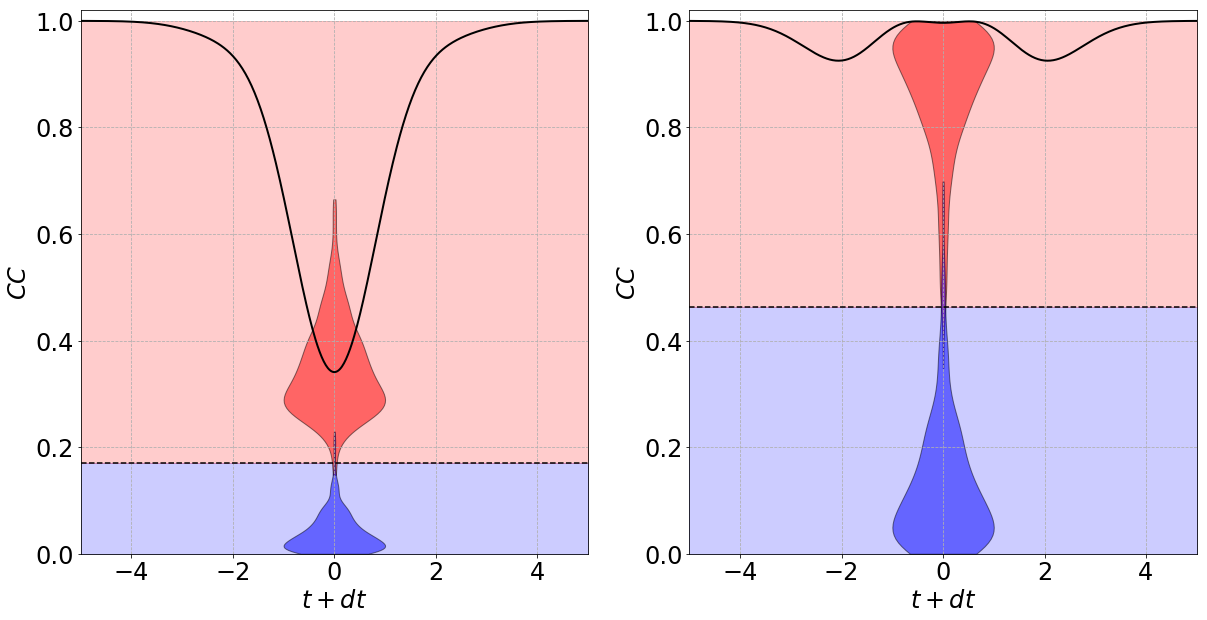

In [34]:
ap = 0.2
sz = 500
fs = 20
wid = 2

# Let's plot the data
plt.figure(figsize=(20,10))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.hlines(np.min(CCb)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCb)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCb)/2, 1, color='r', alpha=ap)

# Add violin plot
v1 = plt.violinplot(X0dipb, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipb, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)

plt.plot(Dtvals, CCa, color='k', linewidth=2)
plt.hlines(np.min(CCa)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCa)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCa)/2, 1, color='r', alpha=ap)

v1 = plt.violinplot(X0dipa, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipa, [0], widths= wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')


plt.show()

#### Clearly after training, the difference is massive. 

In [35]:
# CC before
CCb1 = np.array([HOM(t, dt, Dt, X1before, X1coeffsb[0], d) for Dt in Dtvals])
CCb0 = np.array([HOM(t, dt, Dt, X1before, X0coeffsb[0], d) for Dt in Dtvals])

# CC after
CCa1 = np.array([HOM(t, dt, Dt, X0after, X1coeffsa[0], d) for Dt in Dtvals])
CCa0 = np.array([HOM(t, dt, Dt, X0after, X1after, d) for Dt in Dtvals])

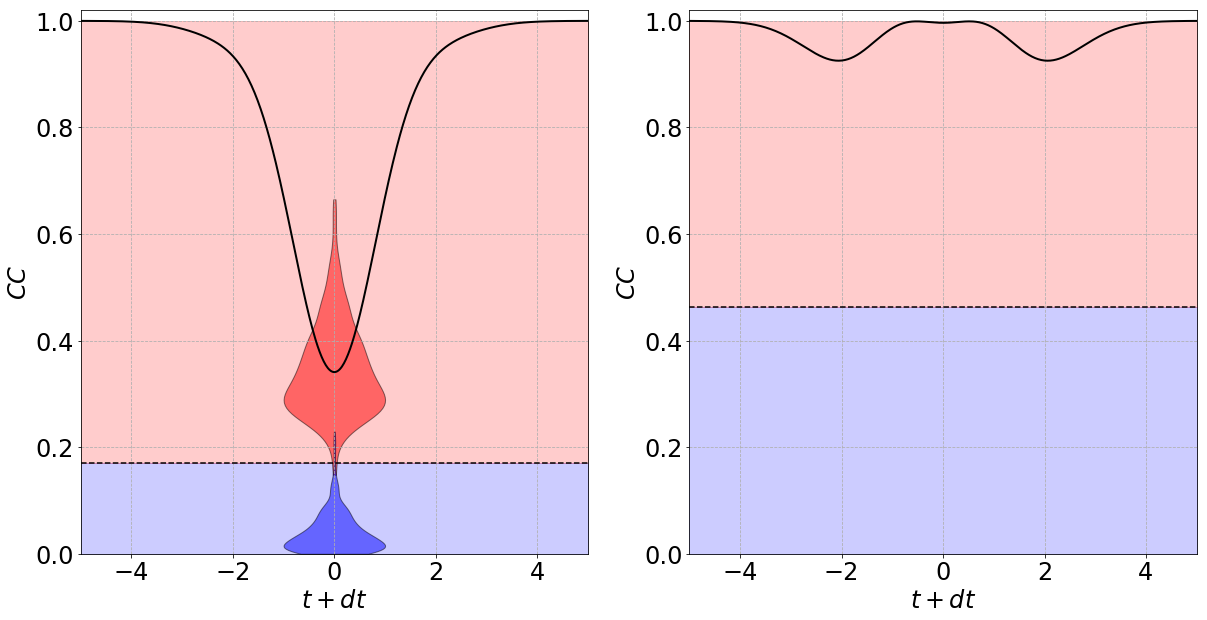

In [36]:
ap = 0.2
sz = 500
fs = 20
wid = 2

# Let's plot the data
plt.figure(figsize=(20,10))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.hlines(np.min(CCb)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCb)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCb)/2, 1, color='r', alpha=ap)

# Add violin plot
v1 = plt.violinplot(X0dipb, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipb, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)

plt.plot(Dtvals, CCa, color='k', linewidth=2)
plt.hlines(np.min(CCa)/2 ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, np.min(CCa)/2, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), np.min(CCa)/2, 1, color='r', alpha=ap)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')


plt.show()